In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#factor是REVS60因子
#adj_factor 累计复权因子数据
#chg_status 股票涨跌停，停牌等状态 -1停牌包括暂停上市，0平量，1上涨不含涨停，2涨停不含一字涨停，3一字涨停，4下跌不含跌停，5跌停不含一字跌停，6一字跌停
#equ_state  股票上市或者ST等状态 1 撤销ST，2 实施ST，3 恢复上市，4 暂停上市，5 退市，nan值是正常状态
#list_days 公司上市天数
#CSI500 中证500指数收益率数据


In [2]:
#导入数据
revs60=pd.read_csv('C:\\Users\\roderickzzc\\Desktop\\Backtest\\factor\\Datayes\\equ_factor_obos\\revs60.csv')

adj_factor=pd.read_csv('C:\\Users\\roderickzzc\\Desktop\\Backtest\\market_data\\adj_factor.csv')

chg_status=pd.read_csv('C:\\Users\\roderickzzc\\Desktop\\Backtest\\market_data\\chg_status.csv')

close_price=pd.read_csv('C:\\Users\\roderickzzc\\Desktop\\Backtest\\market_data\\close_price.csv')

CSI500=pd.read_csv('C:\\Users\\roderickzzc\\Desktop\\Backtest\\market_data\\CSI500.csv')

equ_state=pd.read_csv('C:\\Users\\roderickzzc\\Desktop\\Backtest\\market_data\\equ_state.csv')

list_days=pd.read_csv('C:\\Users\\roderickzzc\\Desktop\\Backtest\\market_data\\list_days.csv')

trade_date=pd.read_csv('C:\\Users\\roderickzzc\\Desktop\\Backtest\\market_data\\trade_date.csv')


In [3]:
#数据处理，时间对齐，股票号码对齐


cols = [i for i in close_price.columns if i not in ['TRADE_DATE']]
close_price = close_price[cols]

list_days['Unnamed: 0'] = pd.to_datetime(list_days['Unnamed: 0'])
criteria = (list_days['Unnamed: 0'] >= pd.Timestamp(2007,1,4))
list_days=list_days[criteria]
criteria = (list_days['Unnamed: 0'] <= pd.Timestamp(2020,2,28))
list_days=list_days[criteria]
list_days = list_days.sort_values(by = 'Unnamed: 0')
list_days=list_days.set_index(['Unnamed: 0'])
cols=close_price.columns
list_days=list_days[cols] 

equ_state.isnull().sum(axis=1)
equ_state['Unnamed: 0'] = pd.to_datetime(equ_state['Unnamed: 0'])
criteria = (equ_state['Unnamed: 0'] >= pd.Timestamp(2007,1,4))
equ_state=equ_state[criteria]
criteria = (equ_state['Unnamed: 0'] <= pd.Timestamp(2020,2,28))
equ_state=equ_state[criteria]
equ_state = equ_state.sort_values(by = 'Unnamed: 0')
equ_state=equ_state.set_index(['Unnamed: 0'])
equ_state=equ_state[cols] 

revs60 = revs60.sort_values(by = 'Unnamed: 0')
revs60['Unnamed: 0'] = pd.to_datetime(revs60['Unnamed: 0'])
revs60=revs60.set_index(['Unnamed: 0'])
revs60=revs60[cols]


adj_factor['TRADE_DATE'] = pd.to_datetime(adj_factor['TRADE_DATE'])
adj_factor=adj_factor.set_index(['TRADE_DATE'])
adj_factor=adj_factor[cols] 


chg_status = chg_status.sort_values(by = 'TRADE_DATE')
chg_status['TRADE_DATE'] = pd.to_datetime(chg_status['TRADE_DATE'])
chg_status=chg_status.set_index(['TRADE_DATE'])
chg_status=chg_status[cols]

criteria = (CSI500['Unnamed: 0'] >= 20070104)
CSI500=CSI500[criteria]
criteria = (CSI500['Unnamed: 0'] <= 20200228)
CSI500=CSI500[criteria]


trade_date['TRADE_DATE'] = pd.to_datetime(trade_date['TRADE_DATE'])
criteria = (trade_date['TRADE_DATE'] >= pd.Timestamp(2007,1,4))
trade_date=trade_date[criteria]
criteria = (trade_date['TRADE_DATE'] <= pd.Timestamp(2020,2,28))
trade_date=trade_date[criteria]
trade_date=trade_date.reset_index(drop=True)
trade_date = trade_date.sort_values(by = 'TRADE_DATE')
trade_date=trade_date[['TRADE_DATE']]

In [4]:
def MA_90(df):
    mean=[]
    for i in range(90,df.shape[0]):
        mean_90=df[i-90:i].sum()/90
        mean.append(mean_90)
    return mean
    
    

C:\Users\roderickzzc\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(0.0, 1.1)

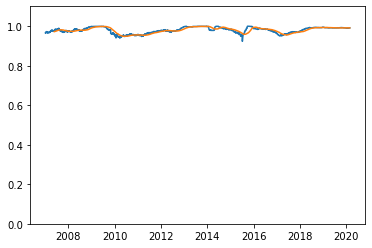

In [5]:
#因子覆盖率


import matplotlib.ticker as ticker
coverage_rate=revs60.count(axis=1)/(chg_status.count(axis=1)-(chg_status == -1).sum(axis=1))
coverage_rate=coverage_rate.reset_index(drop=True)

plt.plot(trade_date,coverage_rate)
plt.plot(trade_date[90:],MA_90(coverage_rate))
plt.ylim(0,1.1)



(0.0, 1.1)

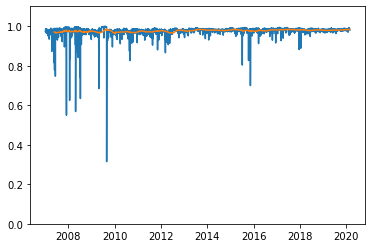

In [6]:
#因子值在时序上的相关性
CORR=[]
for i in range(1,len(revs60)):
    cols=np.where(~np.isnan(revs60.iloc[i-1]))[0].tolist()
    x_t_1=revs60.iloc[i-1,cols]-revs60.iloc[i-1,cols].mean()
    x_t=revs60.iloc[i,cols]-revs60.iloc[i,cols].mean()
    corr=((x_t_1*x_t).sum())/((x_t_1**2).sum()*(x_t**2).sum())**(1/2)
    CORR.append(corr)


plt.plot(trade_date[1:],CORR)
plt.plot(trade_date[91:],MA_90(pd.DataFrame(CORR)))
plt.ylim(0,1.1)


(-0.5, 0.5)

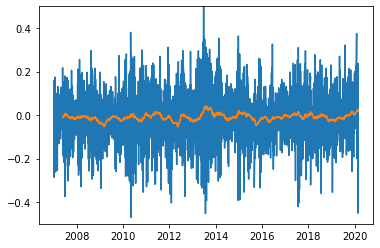

In [7]:
#IC值
close_price.index=adj_factor.index
real_price=close_price*adj_factor
df=real_price.shift(1)
return_rate=(real_price-df)/df


CORR1=[]
for i in range(0,len(revs60[0:-1])):
    #cols_fac=np.where(~np.isnan(revs60[0:-1].iloc[i]))[0].tolist()
    #cols_ret=np.where(~np.isnan(return_rate[1:].iloc[i]))[0].tolist()
    #cols = [i for i in cols_fac if i in cols_ret]
    
    fac=revs60[0:-1].iloc[i]-revs60[0:-1].iloc[i].mean()
    ret=return_rate[1:].iloc[i]-return_rate[1:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR1.append(corr)


plt.plot(trade_date[:-1],CORR1)
plt.plot(trade_date[90:-1],MA_90(pd.DataFrame(CORR1)))
plt.ylim(-0.5,0.5)

<AxesSubplot:>

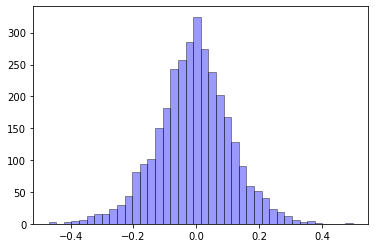

In [8]:
#IC distribution
import seaborn as sns
sns.distplot(CORR1, hist=True, kde=False, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'})

<ipython-input-9-06b058bd46b0>:9: RuntimeWarning: invalid value encountered in double_scalars
  corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)


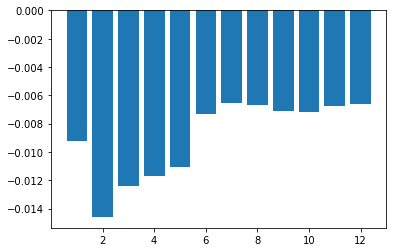

In [9]:
#IC Decay

IC_Decay=[]

CORR0=[]
for i in range(0,len(revs60[0:])):  
    fac=revs60[0:].iloc[i]-revs60[0:].iloc[i].mean()
    ret=return_rate[0:].iloc[i]-return_rate[0:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR0.append(corr)
pd.DataFrame(CORR0).mean()[0]
IC_Decay.append(pd.DataFrame(CORR0).mean()[0])

CORR1=[]
for i in range(0,len(revs60[0:-1])):
    fac=revs60[0:-1].iloc[i]-revs60[0:-1].iloc[i].mean()
    ret=return_rate[1:].iloc[i]-return_rate[1:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR1.append(corr)
IC_Decay.append(pd.DataFrame(CORR1).mean()[0])

CORR2=[]
for i in range(0,len(revs60[0:-2])):
    fac=revs60[0:-2].iloc[i]-revs60[0:-2].iloc[i].mean()
    ret=return_rate[2:].iloc[i]-return_rate[2:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR2.append(corr)
IC_Decay.append(pd.DataFrame(CORR2).mean()[0])

CORR3=[]
for i in range(0,len(revs60[0:-3])):  
    fac=revs60[0:-3].iloc[i]-revs60[0:-3].iloc[i].mean()
    ret=return_rate[3:].iloc[i]-return_rate[3:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR3.append(corr)
IC_Decay.append(pd.DataFrame(CORR3).mean()[0])

CORR4=[]
for i in range(0,len(revs60[0:-4])):
    fac=revs60[0:-4].iloc[i]-revs60[0:-4].iloc[i].mean()
    ret=return_rate[4:].iloc[i]-return_rate[4:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR4.append(corr)
IC_Decay.append(pd.DataFrame(CORR4).mean()[0])

CORR5=[]
for i in range(0,len(revs60[0:-5])):
    fac=revs60[0:-2].iloc[i]-revs60[0:-5].iloc[i].mean()
    ret=return_rate[5:].iloc[i]-return_rate[5:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR5.append(corr)
IC_Decay.append(pd.DataFrame(CORR5).mean()[0])

CORR6=[]
for i in range(0,len(revs60[0:-6])):   
    fac=revs60[0:-6].iloc[i]-revs60[0:-6].iloc[i].mean()
    ret=return_rate[6:].iloc[i]-return_rate[6:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR6.append(corr)
IC_Decay.append(pd.DataFrame(CORR6).mean()[0])

CORR7=[]
for i in range(0,len(revs60[0:-7])):    
    fac=revs60[0:-7].iloc[i]-revs60[0:-7].iloc[i].mean()
    ret=return_rate[7:].iloc[i]-return_rate[7:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR7.append(corr)
IC_Decay.append(pd.DataFrame(CORR7).mean()[0])

CORR8=[]
for i in range(0,len(revs60[0:-8])):    
    fac=revs60[0:-8].iloc[i]-revs60[0:-8].iloc[i].mean()
    ret=return_rate[8:].iloc[i]-return_rate[8:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR8.append(corr)
IC_Decay.append(pd.DataFrame(CORR8).mean()[0])


CORR9=[]
for i in range(0,len(revs60[0:-9])):    
    fac=revs60[0:-9].iloc[i]-revs60[0:-9].iloc[i].mean()
    ret=return_rate[9:].iloc[i]-return_rate[9:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR9.append(corr)
IC_Decay.append(pd.DataFrame(CORR9).mean()[0])

CORR10=[]
for i in range(0,len(revs60[0:-10])):  
    fac=revs60[0:-10].iloc[i]-revs60[0:-10].iloc[i].mean()
    ret=return_rate[10:].iloc[i]-return_rate[10:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR10.append(corr)
IC_Decay.append(pd.DataFrame(CORR10).mean()[0])


CORR11=[]
for i in range(0,len(revs60[0:-11])):   
    fac=revs60[0:-11].iloc[i]-revs60[0:-11].iloc[i].mean()
    ret=return_rate[11:].iloc[i]-return_rate[11:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR11.append(corr)
IC_Decay.append(pd.DataFrame(CORR11).mean()[0])

CORR12=[]
for i in range(0,len(revs60[0:-12])):   
    fac=revs60[0:-12].iloc[i]-revs60[0:-12].iloc[i].mean()
    ret=return_rate[12:].iloc[i]-return_rate[12:].iloc[i].mean()
    corr=((fac*ret).sum())/((fac**2).sum()*(ret**2).sum())**(1/2)
    CORR12.append(corr)
IC_Decay.append(pd.DataFrame(CORR12).mean()[0])

plt.bar(range(1,len(IC_Decay)), IC_Decay[1:])
plt.show()

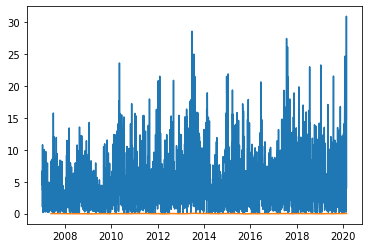

In [152]:
#t statistics time series
t_values=[]
r_square=[]
for i in range(0,len(revs60)-1):
    y=list(return_rate.iloc[i+1,0:])
    x=list(revs60.iloc[i,0:])
    d={'revs60':x,'Return rate':y}
    df=pd.DataFrame(d)
    df=df.dropna(axis=0,how='any')
    X = df[['revs60']]
    Y = df['Return rate']

    model = sm.OLS(Y,sm.add_constant(X), data=df,missing='drop').fit()
    t=model.t_test([0, 1]).tvalue[0][0]
    t_values.append(t)
    r_2=model.rsquared
    r_square.append(r_2)


abs_t =  [abs(ele) for ele in t_values] 
plt.plot(trade_date[:-1],abs_t)
plt.plot(trade_date[90:-1],MA_90(pd.DataFrame(abs_t)))

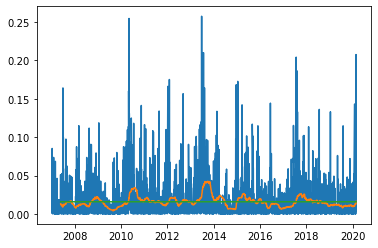

In [161]:
#Adjusted R-squared time series
plt.plot(trade_date[:-1],r_square)
plt.plot(trade_date[90:-1],MA_90(pd.DataFrame(r_square)))
plt.plot(trade_date[90:-1],[pd.DataFrame(r_square).mean()[0]]*len(trade_date[90:-1]))

In [601]:
import math
df=revs60.T.iloc[:,0].dropna(axis=0,how='any')


def split_n_groups(n,df):
    df=df.sort_values()
    length=len(df)
    groups=[]
    for i in range(n):
        splitted = df[math.floor(i / n * length):math.floor((i + 1) / n * length)]
        data=pd.DataFrame({'Q%d' %(i+1):splitted })
        groups.append(data)
    return groups
        #yield data

def compute_output(input_money,start_day,end_day,portfolio):
    startday_price=real_price[portfolio].loc[start_day]
    endday_price=real_price[portfolio].loc[end_day]
    return_rate=(((endday_price-startday_price)/startday_price)).mean()
    output_money=(1+return_rate)*input_money
    return output_money
    
    

def relocation_dates(n):
    dates=[trade_date['TRADE_DATE'][i].strftime('%Y-%m-%d') for i in range(len(trade_date))][::n]
    return dates

def cal_relocation_cost(start,end,group_index,input_money,output_money):
    df_start=revs60.T[start].dropna(axis=0,how='any')
    groups_start=split_n_groups(10,df_start)
    df_end=revs60.T[end].dropna(axis=0,how='any')
    groups_end=split_n_groups(10,df_end)

    portfolio_start=groups_start[group_index].index.tolist()
    portfolio_end=groups_end[group_index].index.tolist()
    portfolio_keep=list(set(portfolio_start).intersection(portfolio_end))
    portfolio_sell_all=list(set(portfolio_start).difference(portfolio_end))
    portfolio_buy_all=list(set(portfolio_end).difference(portfolio_start))

    startday_price=real_price[portfolio_start].loc[start]
    endday_price=real_price[portfolio_start].loc[end]
    return_rate=(((endday_price-startday_price)/startday_price))
    #return_rate
    now_location=(return_rate+1)*(1/len(portfolio_start))*input_money
    now_location_keep=now_location[portfolio_keep]
    next_money_in_each_stock=output_money/len(portfolio_end)
    deviation=next_money_in_each_stock-now_location_keep
    sell_money_keep=sum(x for x in deviation if x > 0)
    buy_money_keep=sum(-x for x in deviation if x < 0)
    #sell_money
    #buy_money

    now_location_sell=now_location[portfolio_sell_all]
    sell_money=now_location_sell.sum()+sell_money_keep
    buy_money=len(portfolio_buy_all)*next_money_in_each_stock+buy_money_keep
    return sell_money*(0.0003+0.002+0.001)+buy_money*(0.0003+0.002)


def strategy_return(relocation_frequency,group_index,trans_cost=True):
    input_money=1
    if trans_cost==True:
        input_money=input_money-input_money*(0.0003+0.002)
    result=[]
    for i in range(0,len(relocation_dates(relocation_frequency))-1):
        dates=relocation_dates(relocation_frequency)
        start=dates[i]
        end=dates[i+1]
        df_start=revs60.T[start].dropna(axis=0,how='any')
        groups_start=split_n_groups(10,df_start)
        df_end=revs60.T[end].dropna(axis=0,how='any')
        groups_end=split_n_groups(10,df_end)
        output_money=compute_output(input_money,start,end,groups_start[group_index].index.tolist())
        if trans_cost==True:
            output_money=output_money-cal_relocation_cost(start,end,group_index,input_money,output_money)
        result.append(output_money)
        input_money=output_money
    return result



In [602]:
r0=strategy_return(relocation_frequency,0)
r1=strategy_return(relocation_frequency,1)
r2=strategy_return(relocation_frequency,2)
r3=strategy_return(relocation_frequency,3)
r4=strategy_return(relocation_frequency,4)
r5=strategy_return(relocation_frequency,5)
r6=strategy_return(relocation_frequency,6)
r7=strategy_return(relocation_frequency,7)
r8=strategy_return(relocation_frequency,8)
r9=strategy_return(relocation_frequency,9)

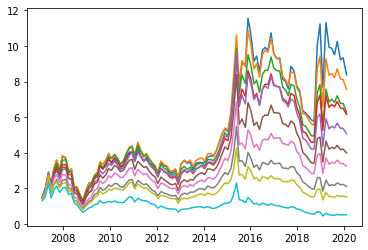

In [603]:
#Net Asset Value
relocation_frequency=30
plt.plot(trade_date[relocation_frequency::relocation_frequency],r0)
plt.plot(trade_date[relocation_frequency::relocation_frequency],r1)
plt.plot(trade_date[relocation_frequency::relocation_frequency],r2)
plt.plot(trade_date[relocation_frequency::relocation_frequency],r3)
plt.plot(trade_date[relocation_frequency::relocation_frequency],r4)
plt.plot(trade_date[relocation_frequency::relocation_frequency],r5)
plt.plot(trade_date[relocation_frequency::relocation_frequency],r6)
plt.plot(trade_date[relocation_frequency::relocation_frequency],r7)
plt.plot(trade_date[relocation_frequency::relocation_frequency],r8)
plt.plot(trade_date[relocation_frequency::relocation_frequency],r9)


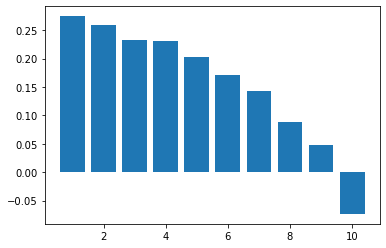

In [604]:
#Annualized Return
r=[r0,r1,r2,r3,r4,r5,r6,r7,r8,r9]
def annualize_return(total_money_at_end):
    annual_return=total_money_at_end**(365/3198)-1
    return annual_return

return_=[]
for i in range(0,10):
    return_of_group_i=annualize_return(r[i][-1])
    return_.append(return_of_group_i)


plt.bar(range(1,11), return_)
plt.show()

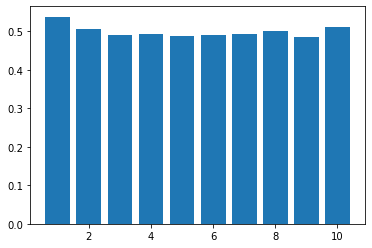

In [606]:
#Annualized Volatility
s0=np.std(np.log(np.array(r0[1:])/np.array(r0[:-1])))*np.sqrt(12)
s1=np.std(np.log(np.array(r1[1:])/np.array(r1[:-1])))*np.sqrt(12)
s2=np.std(np.log(np.array(r2[1:])/np.array(r2[:-1])))*np.sqrt(12)
s3=np.std(np.log(np.array(r3[1:])/np.array(r3[:-1])))*np.sqrt(12)
s4=np.std(np.log(np.array(r4[1:])/np.array(r4[:-1])))*np.sqrt(12)
s5=np.std(np.log(np.array(r5[1:])/np.array(r5[:-1])))*np.sqrt(12)
s6=np.std(np.log(np.array(r6[1:])/np.array(r6[:-1])))*np.sqrt(12)
s7=np.std(np.log(np.array(r7[1:])/np.array(r7[:-1])))*np.sqrt(12)
s8=np.std(np.log(np.array(r8[1:])/np.array(r8[:-1])))*np.sqrt(12)
s9=np.std(np.log(np.array(r9[1:])/np.array(r9[:-1])))*np.sqrt(12)

plt.bar(range(1,11),[s0,s1,s2,s3,s4,s5,s6,s7,s8,s9])
plt.show()

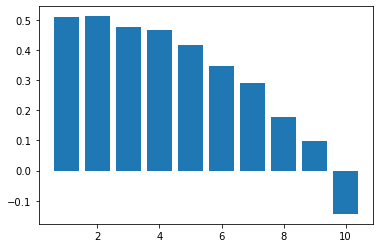

In [607]:
#Sharpe Ratio
sp=np.array(return_)/np.array([s0,s1,s2,s3,s4,s5,s6,s7,s8,s9])
plt.bar(range(1,11),sp)
plt.show()

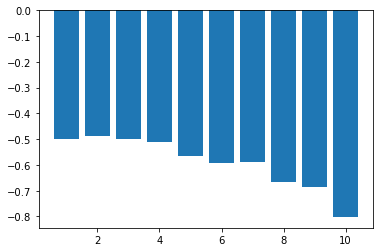

In [608]:
#Maximum drawdown
Max_dd0=(min(r0[r0.index(max(r0)):])-max(r0))/max(r0)
Max_dd1=(min(r1[r1.index(max(r1)):])-max(r1))/max(r1)
Max_dd2=(min(r2[r2.index(max(r2)):])-max(r2))/max(r2)
Max_dd3=(min(r3[r3.index(max(r3)):])-max(r3))/max(r3)
Max_dd4=(min(r4[r4.index(max(r4)):])-max(r4))/max(r4)
Max_dd5=(min(r5[r5.index(max(r5)):])-max(r5))/max(r5)
Max_dd6=(min(r6[r6.index(max(r6)):])-max(r6))/max(r6)
Max_dd7=(min(r7[r7.index(max(r7)):])-max(r7))/max(r7)
Max_dd8=(min(r8[r8.index(max(r8)):])-max(r8))/max(r8)
Max_dd9=(min(r9[r9.index(max(r9)):])-max(r9))/max(r9)
MDD=[Max_dd0,Max_dd1,Max_dd2,Max_dd3,Max_dd4,Max_dd5,Max_dd6,Max_dd7,Max_dd8,Max_dd9]
plt.bar(range(1,11),MDD)
plt.show()

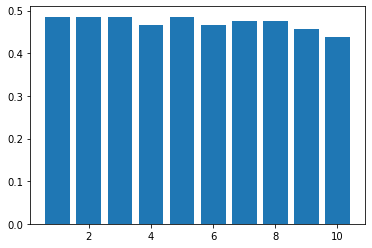

In [609]:
#Winning rate
def cal_win_rate(r):
    a=np.array(r[1:])-np.array(r[:-1])
    win_rate=np.sum(a>0)/len(a)
    return win_rate
WIN_RATE=[cal_win_rate(r0),cal_win_rate(r1),cal_win_rate(r2),cal_win_rate(r3),cal_win_rate(r4),cal_win_rate(r5),cal_win_rate(r6),cal_win_rate(r7),cal_win_rate(r8),cal_win_rate(r9)]
plt.bar(range(1,11),WIN_RATE)
plt.show()

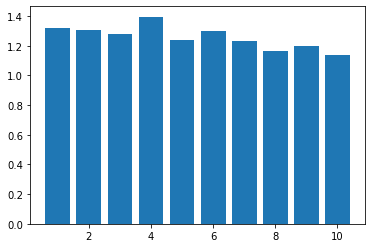

In [610]:
#PL Ratio
def cal_PL_rate(r):
    a=(np.array(r[1:])-np.array(r[:-1]))
    PL_rate=a[a>0].mean()/(-a[a<0].mean()) #a[a<0].mean是负值
    return PL_rate

PL_RATE=[cal_PL_rate(r0),cal_PL_rate(r1),cal_PL_rate(r2),cal_PL_rate(r3),cal_PL_rate(r4),cal_PL_rate(r5),cal_PL_rate(r6),cal_PL_rate(r7),cal_PL_rate(r8),cal_PL_rate(r9)]
plt.bar(range(1,11),PL_RATE)
plt.show()

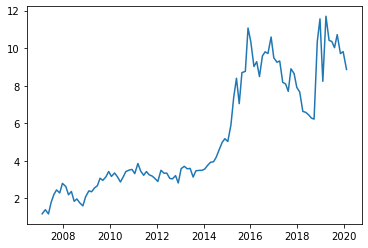

In [690]:
#long-short portfolio
plt.plot(trade_date[relocation_frequency::relocation_frequency],(np.array(r0)-np.array(r9))+1)

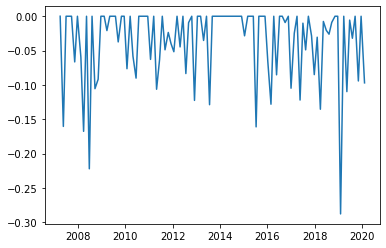

In [691]:
#long-short drawdown
r_ls=(np.array(r0)-np.array(r9))+1
chg=(np.array(r_ls[1:])-np.array(r_ls[:-1]))/np.array(r_ls[:-1])
chg[chg>0]=0
plt.plot(trade_date[relocation_frequency*2::relocation_frequency],chg)

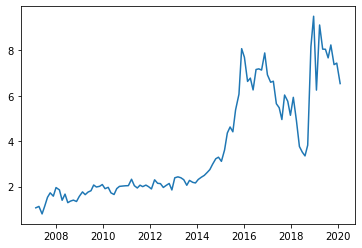

In [692]:
#Benchmark hedged portfolio
ret_csi=np.array(CSI500['CSI500'])+1
ret_CSI=[]
for i in trade_date[relocation_frequency::relocation_frequency].index.tolist():
    a=np.prod(ret_csi[0:i])
    ret_CSI.append(a)


plt.plot(trade_date[relocation_frequency::relocation_frequency],((np.array(r0)-np.array(ret_CSI))+1))

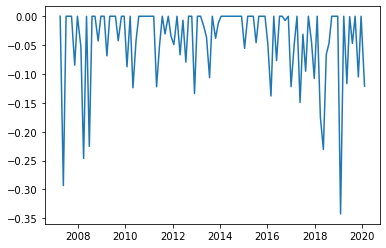

In [693]:
#Benchmark hedged drwadown
r_ls=(np.array(r0)-np.array(ret_CSI))+1
chg=(np.array(r_ls[1:])-np.array(r_ls[:-1]))/np.array(r_ls[:-1])
chg[chg>0]=0
plt.plot(trade_date[relocation_frequency*2::relocation_frequency],chg)